# **BLACKJACK**

# **Interactive Black Jack using Basic Strategy**

In [ ]:
import random
import numpy as np

# Define card values
def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def sum_hand(hand):
    total = sum(hand)
    num_aces = hand.count(1)

    while total + 10 <= 21 and num_aces > 0:
        total += 10
        num_aces -= 1

    return total

def is_bust(hand):
    return sum_hand(hand) > 21

def is_blackjack(hand):
    return sum_hand(hand) == 21 and len(hand) == 2

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

class Blackjack:
    def __init__(self):
        self.player_hand = draw_hand()
        self.dealer_hand = draw_hand()

    def reset(self):
        self.player_hand = draw_hand()
        self.dealer_hand = draw_hand()
        return (sum_hand(self.player_hand), self.dealer_hand[0], False)

    def step(self, action):
        if action == 1:  # Hit
            self.player_hand.append(draw_card())
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), -1, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], False), 0, False
        else:  # Stand
            while sum_hand(self.dealer_hand) < 17:
                self.dealer_hand.append(draw_card())
            player_score = score(self.player_hand)
            dealer_score = score(self.dealer_hand)
            if is_bust(self.dealer_hand) or player_score > dealer_score:
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), 1, True
            elif player_score == dealer_score:
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), 0, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), -1, True

def basic_strategy(player_sum, dealer_up_card):
    # Basic strategy for hard totals
    if player_sum >= 17:
        return 0  # Stand
    elif player_sum >= 13 and dealer_up_card <= 6:
        return 0  # Stand
    elif player_sum >= 12 and 4 <= dealer_up_card <= 6:
        return 0  # Stand
    else:
        return 1  # Hit

# Evaluate the basic strategy
def evaluate_basic_strategy(num_episodes):
    env = Blackjack()
    wins, draws, losses = 0, 0, 0
    total_reward = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            player_sum, dealer_up_card, _ = state
            action = basic_strategy(player_sum, dealer_up_card)
            state, reward, done = env.step(action)

        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

    win_percentage = wins / num_episodes * 100
    avg_reward = total_reward / num_episodes
    avg_win_rate = wins / num_episodes

    return win_percentage, avg_reward, avg_win_rate

def user_play():
    env = Blackjack()
    state = env.reset()
    done = False

    print(f"Dealer's up card: {state[1]}")

    while not done:
        player_sum, dealer_up_card, _ = state
        print(f"Your hand: {env.player_hand} (Total: {player_sum})")
        if player_sum == 21:
            print("You have a perfect 21!")
        action = input("Do you want to [h]it or [s]tay? ").strip().lower()
        if action == 'h':
            action = 1
        elif action == 's':
            action = 0
        else:
            print("Invalid input, please choose 'h' or 's'.")
            continue

        state, reward, done = env.step(action)

        if is_bust(env.player_hand):
            print(f"Your hand: {env.player_hand} (Total: {sum_hand(env.player_hand)})")
            break

    # Show the dealer's full hand
    print(f"Dealer's hand: {env.dealer_hand} (Total: {sum_hand(env.dealer_hand)})")

    if is_bust(env.dealer_hand):
        print("The dealer is bust!")
    elif sum_hand(env.dealer_hand) == 21:
        print("Dealer has a perfect 21!")

    if is_bust(env.player_hand):
        print("You are bust! Dealer Win!")
    elif reward > 0:
        print("You win!")
    elif reward == 0:
        print("It's a draw!")
    else:
        print("You lose!")

# Let the user play one game
print("Let's play a game of Blackjack!")
user_play()

Let's play a game of Blackjack!
Dealer's up card: 5
Your hand: [4, 2] (Total: 6)
Do you want to [h]it or [s]tay? s
Dealer's hand: [5, 10, 8] (Total: 23)
The dealer is bust!
You win!


In [ ]:
# Run the basic strategy for a number of episodes and calculate stats
num_eval_episodes = 100000
win_percentage, avg_reward, avg_win_rate = evaluate_basic_strategy(num_eval_episodes)
print(f"Win Percentage: {win_percentage:.2f}%")
print(f"Average Reward: {avg_reward:.2f}")
print(f"Average Win Rate: {avg_win_rate:.2f}")

Win Percentage: 42.32%
Average Reward: -0.06
Average Win Rate: 0.42


# **Basic Strategy with Q Learning**

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions
def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def sum_hand(hand):
    total = sum(hand)
    num_aces = hand.count(1)

    while total + 10 <= 21 and num_aces > 0:
        total += 10
        num_aces -= 1

    return total

def is_bust(hand):
    return sum_hand(hand) > 21

def is_blackjack(hand):
    return sum_hand(hand) == 21 and len(hand) == 2

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)


In [ ]:
# Game Environment
class Blackjack:
    def __init__(self):
        self.player_hand = draw_hand()
        self.dealer_hand = draw_hand()
        self.split_hand = None
        self.double_down = False

    def reset(self):
        self.player_hand = draw_hand()
        self.dealer_hand = draw_hand()
        self.split_hand = None
        self.double_down = False
        return (sum_hand(self.player_hand), self.dealer_hand[0], False)

    def step(self, action):
        if action == 1:  # Hit
            self.player_hand.append(draw_card())
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), -1, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], False), 0, False
        elif action == 2:  # Double Down
            self.double_down = True
            self.player_hand.append(draw_card())
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), -2, True
            else:
                return self.resolve_game()
        elif action == 3:  # Split
            self.split_hand = [self.player_hand.pop()]
            self.player_hand.append(draw_card())
            self.split_hand.append(draw_card())
            return (sum_hand(self.player_hand), self.dealer_hand[0], False), 0, False
        else:  # Stand
            return self.resolve_game()

    def resolve_game(self):
        while sum_hand(self.dealer_hand) < 17:
            self.dealer_hand.append(draw_card())
        player_score = score(self.player_hand)
        dealer_score = score(self.dealer_hand)
        if self.split_hand:
            split_score = score(self.split_hand)
        else:
            split_score = None
        if is_bust(self.dealer_hand) or player_score > dealer_score:
            reward = 2 if self.double_down else 1
            return (sum_hand(self.player_hand), self.dealer_hand[0], True), reward, True
        elif player_score == dealer_score:
            return (sum_hand(self.player_hand), self.dealer_hand[0], True), 0, True
        else:
            reward = -2 if self.double_down else -1
            return (sum_hand(self.player_hand), self.dealer_hand[0], True), reward, True


In [ ]:
# Q-Learning Agent

class QLearningAgent:
    def __init__(self, state_space_size, action_space_size, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_table = np.zeros((state_space_size, action_space_size))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 3)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] = self.q_table[state, action] + self.alpha * (target - predict)


In [ ]:
# State Mapping
def state_to_index(player_sum, dealer_up_card):
    if player_sum < 4:
        player_sum = 4
    elif player_sum > 21:
        player_sum = 21
    return (player_sum - 4) * 10 + (dealer_up_card - 1)

# Evaluate the Q-learning agent and track win percentage and Q-value progression over time
def evaluate_q_learning_agent(agent, num_episodes, track_states, track_interval=100):
    env = Blackjack()
    wins, draws, losses = 0, 0, 0
    total_reward = 0
    win_percentages = []
    cumulative_win_percentage = []
    q_value_progression = {state: {action: [] for action in range(4)} for state in track_states}

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state_to_index(state[0], state[1])
        done = False

        while not done:
            action = agent.choose_action(state_index)
            next_state, reward, done = env.step(action)
            next_state_index = state_to_index(next_state[0], next_state[1])
            agent.learn(state_index, action, reward, next_state_index)
            state_index = next_state_index

        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

        if (episode + 1) % track_interval == 0:
            win_percentage = wins / (episode + 1) * 100
            win_percentages.append(win_percentage)

        cumulative_win_percentage.append(wins / (episode + 1) * 100)

        if (episode + 1) % track_interval == 0:
            for (player_sum, dealer_up_card) in track_states:
                state_index = state_to_index(player_sum, dealer_up_card)
                for action in range(4):
                    q_value_progression[(player_sum, dealer_up_card)][action].append(agent.q_table[state_index, action])

    avg_reward = total_reward / num_episodes
    avg_win_rate = wins / num_episodes
    overall_win_percentage = wins / num_episodes * 100

    return win_percentages, cumulative_win_percentage, q_value_progression, avg_reward, avg_win_rate, overall_win_percentage


In [ ]:
# Plotting Functions
def plot_results(win_percentages, cumulative_win_percentage, q_value_progression, track_interval):
    episodes = [i * track_interval for i in range(1, len(win_percentages) + 1)]

    # Plot win percentage over time
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, win_percentages, label='Win Percentage Over Time')
    plt.xlabel('Episodes')
    plt.ylabel('Win Percentage')
    plt.title('Win Percentage Over Time')
    plt.legend()
    plt.grid(True)

    # Plot cumulative win percentage over episodes
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_win_percentage) + 1), cumulative_win_percentage, label='Cumulative Win Percentage')
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Win Percentage')
    plt.title('Cumulative Win Percentage Over Episodes')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot Q-value progression
    action_labels = ['Stand', 'Hit', 'Double Down', 'Split']
    episodes_q = [i * track_interval for i in range(1, len(next(iter(q_value_progression.values()))[0]) + 1)]

    for state, actions in q_value_progression.items():
        plt.figure(figsize=(12, 6))
        for action, q_values in actions.items():
            plt.plot(episodes_q, q_values, label=f'Action {action}: {action_labels[action]}')
        plt.xlabel('Episodes')
        plt.ylabel('Q-Value')
        plt.title(f'Q-Value Progression for State {state}')
        plt.legend()
        plt.grid(True)
        plt.show()


Evaluating Q-Learning Agent:
Overall Win Percentage: 45.95%, Avg Reward: -0.0727, Avg Win Rate: 0.4595


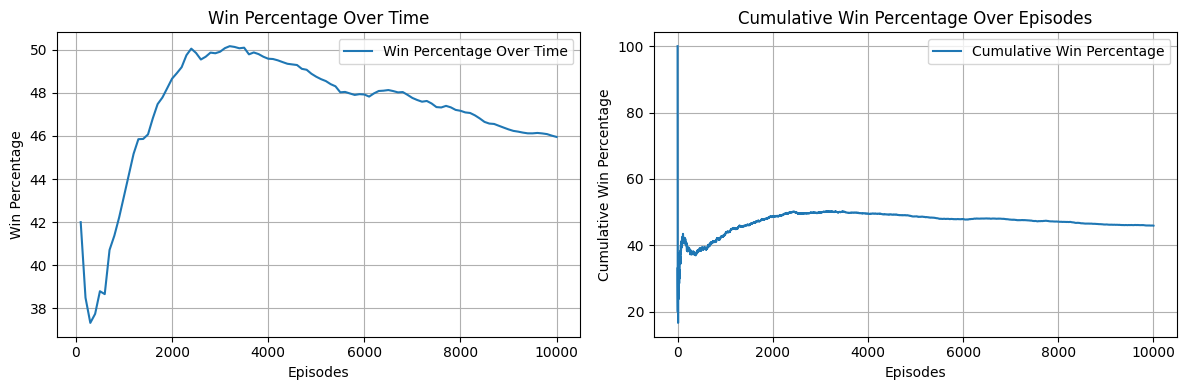

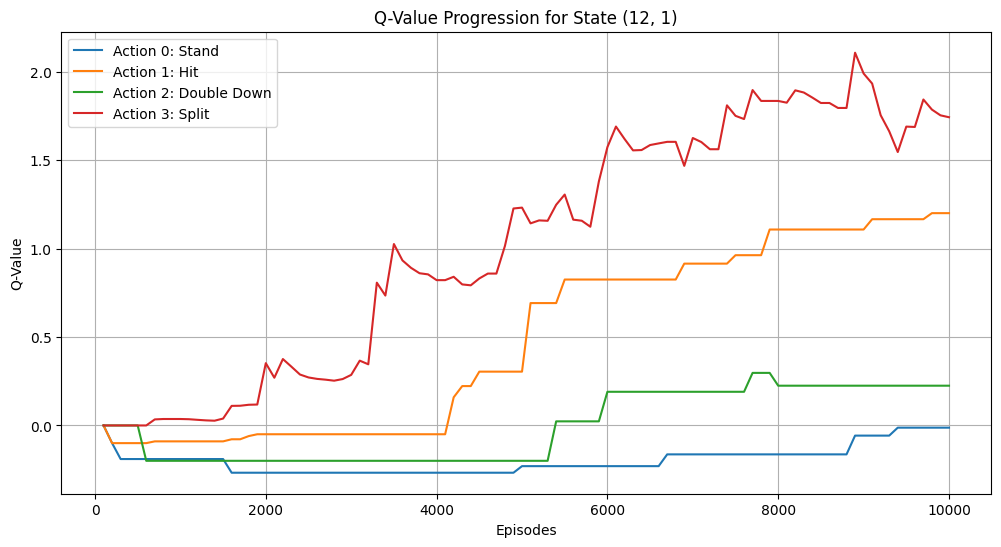

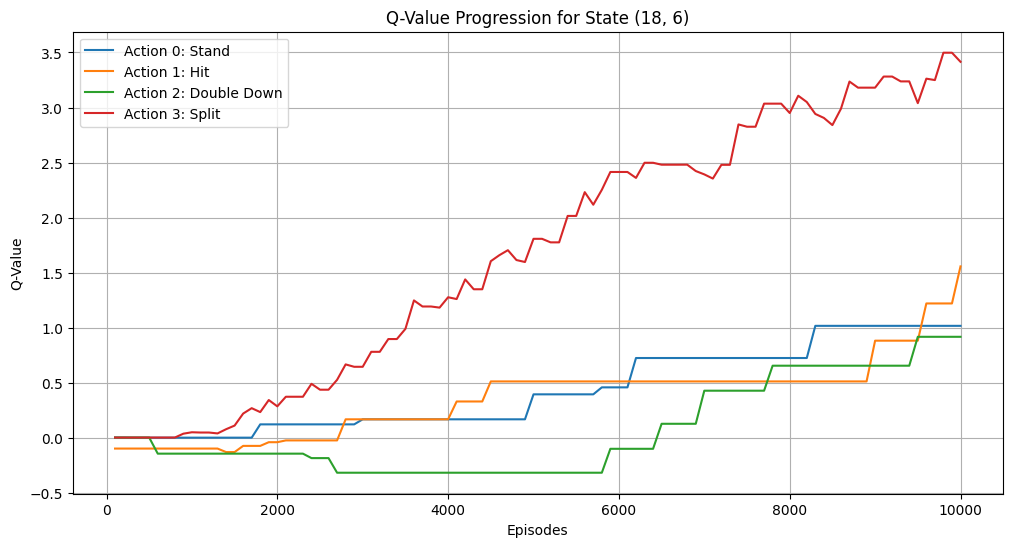

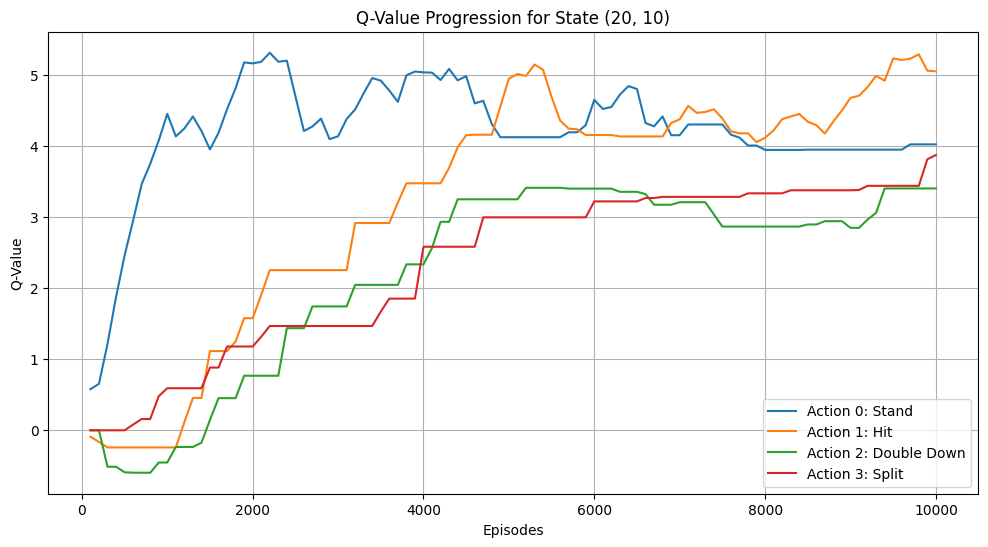

In [ ]:
# Main Execution
if __name__ == "__main__":
    num_episodes = 10000
    track_interval = 100
    state_space_size = (21 - 4 + 1) * 10  # Player sum (4-21) * Dealer up card (1-10)
    action_space_size = 4  # Hit, Stand, Double Down, Split

    # States to track (example: (player_sum, dealer_up_card))
    track_states = [(12, 1), (18, 6), (20, 10)]

    agent = QLearningAgent(state_space_size, action_space_size)
    print("Evaluating Q-Learning Agent:")
    win_percentages, cumulative_win_percentage, q_value_progression, avg_reward, avg_win_rate, overall_win_percentage = evaluate_q_learning_agent(agent, num_episodes, track_states, track_interval)
    print(f"Overall Win Percentage: {overall_win_percentage}%, Avg Reward: {avg_reward}, Avg Win Rate: {avg_win_rate}")

    # Plot the results
    plot_results(win_percentages, cumulative_win_percentage, q_value_progression, track_interval)


# **Complete Point-Count System**

Evaluating Complete Count Q-Learning Agent:
Overall Win Percentage: 45.660000000000004%
Avg Reward: -0.0388
Avg Win Rate: 0.4566


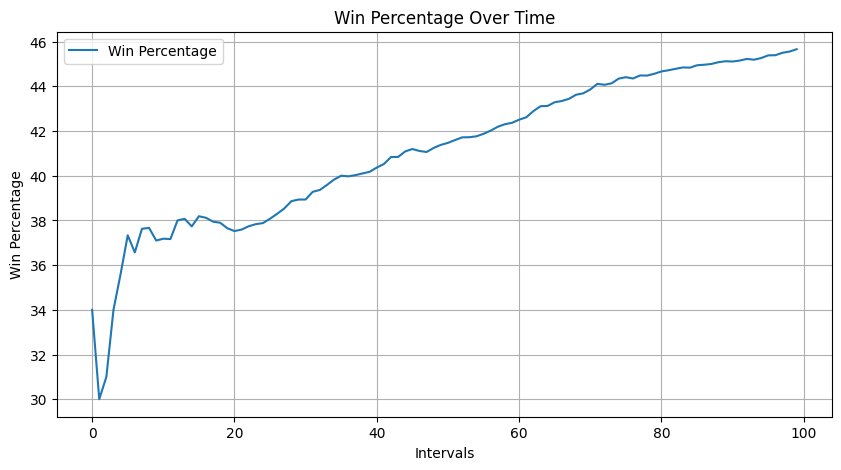

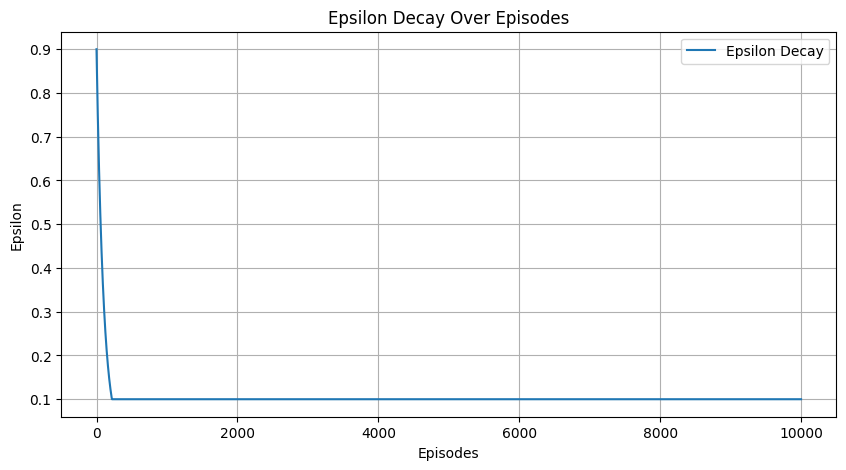

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define card values
def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def sum_hand(hand):
    total = sum(hand)
    num_aces = hand.count(1)

    while total + 10 <= 21 and num_aces > 0:
        total += 10
        num_aces -= 1

    return total

def is_bust(hand):
    return sum_hand(hand) > 21

def is_blackjack(hand):
    return sum_hand(hand) == 21 and len(hand) == 2

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

# Game Environment
class CompleteCountBlackjack:
    def __init__(self):
        self.player_hand = draw_hand()
        self.dealer_hand = draw_hand()
        self.split_hand = None
        self.double_down = False
        self.point_count = 0
        self.unseen_cards = 52
        self.deck_size = 52  # Assuming single deck, adjust if using multiple decks
        self.bet = 1
        self.update_count(self.player_hand + self.dealer_hand)

    def reset(self):
        self.player_hand = draw_hand()
        self.dealer_hand = draw_hand()
        self.split_hand = None
        self.double_down = False
        self.point_count = 0
        self.unseen_cards = self.deck_size
        self.bet = 1
        self.update_count(self.player_hand + self.dealer_hand)
        return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration())

    def step(self, action):
        if action == 1:  # Hit
            card = draw_card()
            self.player_hand.append(card)
            self.update_count([card])
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), -self.bet, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), 0, False
        elif action == 2:  # Double Down
            self.double_down = True
            self.bet *= 2
            card = draw_card()
            self.player_hand.append(card)
            self.update_count([card])
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), -self.bet, True
            else:
                return self.resolve_game()
        elif action == 3:  # Split
            self.split_hand = [self.player_hand.pop()]
            card1 = draw_card()
            card2 = draw_card()
            self.player_hand.append(card1)
            self.split_hand.append(card2)
            self.update_count([card1, card2])
            return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), 0, False
        else:  # Stand
            return self.resolve_game()

    def resolve_game(self):
        while sum_hand(self.dealer_hand) < 17:
            card = draw_card()
            self.dealer_hand.append(card)
            self.update_count([card])
        player_score = score(self.player_hand)
        dealer_score = score(self.dealer_hand)
        if self.split_hand:
            split_score = score(self.split_hand)
        else:
            split_score = None
        if is_bust(self.dealer_hand) or player_score > dealer_score:
            reward = self.bet if not self.double_down else 2 * self.bet
            return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), reward, True
        elif player_score == dealer_score:
            return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), 0, True
        else:
            reward = -self.bet if not self.double_down else -2 * self.bet
            return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), reward, True

    def update_count(self, cards):
        for card in cards:
            if card in [2, 3, 4, 5, 6]:
                self.point_count += 1
            elif card in [10, 11, 12, 13]:
                self.point_count -= 1
        self.unseen_cards -= len(cards)

    def get_high_low_index(self):
        if self.unseen_cards == 0:
            return 0
        return self.point_count / self.unseen_cards

    def get_deck_penetration(self):
        return 1 - (self.unseen_cards / self.deck_size)

    def adjust_bet(self):
        high_low_index = self.get_high_low_index()
        if high_low_index <= 2:
            self.bet = 1
        elif high_low_index <= 4:
            self.bet = 2
        elif high_low_index <= 6:
            self.bet = 3
        elif high_low_index <= 8:
            self.bet = 4
        else:
            self.bet = 5

    def get_action(self, player_sum, dealer_up_card, high_low_index, deck_penetration, soft=False):
        # Adjust strategies based on deck penetration
        if deck_penetration > 0.75:
            # More aggressive strategy if deep into the deck
            if player_sum == 16 and dealer_up_card in [9, 10, 1] and high_low_index > 0:
                return 0  # Stand
            if player_sum == 15 and dealer_up_card in [10] and high_low_index > 4:
                return 0  # Stand
        # Detailed strategy for hitting and standing based on the High-Low Index
        if soft:
            if player_sum == 18:
                if dealer_up_card in [9, 10, 1]:
                    return 1 if high_low_index <= 2 else 0  # Hit if index is low, stand if high
                else:
                    return 0  # Stand
            elif player_sum == 19 and dealer_up_card == 6 and high_low_index > 1:
                return 1  # Hit
            else:
                return 0  # Stand
        else:
            if player_sum >= 17:
                return 0  # Stand
            elif player_sum <= 11:
                return 1  # Hit
            elif player_sum == 12:
                if dealer_up_card in [4, 5, 6] and high_low_index > 0:
                    return 0  # Stand
                else:
                    return 1  # Hit
            elif 13 <= player_sum <= 16:
                if dealer_up_card in [2, 3, 4, 5, 6]:
                    return 0  # Stand
                else:
                    return 1  # Hit
            return 1  # Default to Hit for other cases

    def should_double_down(self, player_sum, dealer_up_card, high_low_index, deck_penetration):
        # Adjust double down strategy based on deck penetration
        if deck_penetration > 0.75 and player_sum in [10, 11] and high_low_index > 1:
            return True
        # Detailed rules for doubling down based on the High-Low Index
        if player_sum == 9:
            if dealer_up_card in [3, 4, 5, 6] and high_low_index > 0:
                return True
        elif player_sum == 10:
            if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9] and high_low_index > -1:
                return True
        elif player_sum == 11:
            if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9, 10] and high_low_index > -2:
                return True
        return False

    def should_split(self, player_card, dealer_up_card, high_low_index, deck_penetration):
        # Adjust split strategy based on deck penetration
        if deck_penetration > 0.75 and player_card == 9 and dealer_up_card == 7 and high_low_index > 1:
            return True
        # Detailed rules for splitting based on the High-Low Index
        if player_card == 8:
            return True
        if player_card == 9:
            if dealer_up_card in [2, 3, 4, 5, 6, 8, 9] and high_low_index > 0:
                return True
        if player_card == 7:
            if dealer_up_card in [2, 3, 4, 5, 6, 7] and high_low_index > 1:
                return True
        if player_card == 6:
            if dealer_up_card in [2, 3, 4, 5, 6] and high_low_index > 2:
                return True
        if player_card == 2 or player_card == 3:
            if dealer_up_card in [2, 3, 4, 5, 6, 7] and high_low_index > 1:
                return True
        return False

    def should_take_insurance(self, high_low_index):
        # Take insurance if the High-Low Index is high enough
        return high_low_index > 3

# Q-Learning Agent
class CompleteCountQLearningAgent:
    def __init__(self, state_space_size, action_space_size, alpha=0.0001, gamma=0.1, epsilon=0.9):
        self.q_table = np.zeros((state_space_size, action_space_size))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 3)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] = self.q_table[state, action] + self.alpha * (target - predict)

# Mapping state to an index for Q-table
def state_to_index(player_sum, dealer_up_card, high_low_index, deck_penetration):
    if player_sum < 4:
        player_sum = 4
    elif player_sum > 21:
        player_sum = 21
    return (player_sum - 4) * 1000 + (dealer_up_card - 1) * 100 + int(high_low_index * 10 + 50) * 10 + int(deck_penetration * 10)  # Adjusting for high-low index and deck penetration

# Evaluate the Q-learning agent and track win percentage and Q-value progression over time
def evaluate_complete_count_agent(agent, num_episodes, track_states, track_interval=100):
    env = CompleteCountBlackjack()
    wins, draws, losses = 0, 0, 0
    total_reward = 0
    win_percentages = []
    cumulative_win_percentage = []
    q_value_progression = {state: {action: [] for action in range(4)} for state in track_states}
    epsilon_values = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state_to_index(state[0], state[1], state[2], state[3])
        env.adjust_bet()  # Adjust the bet based on the High-Low Index
        done = False

        while not done:
            action = agent.choose_action(state_index)
            if action == 2 and not env.should_double_down(state[0], state[1], state[2], state[3]):
                action = agent.choose_action(state_index)  # Re-choose if double down is not appropriate
            if action == 3 and not env.should_split(state[0], state[1], state[2], state[3]):
                action = agent.choose_action(state_index)  # Re-choose if split is not appropriate
            next_state, reward, done = env.step(action)
            next_state_index = state_to_index(next_state[0], next_state[1], next_state[2], next_state[3])
            agent.learn(state_index, action, reward, next_state_index)
            state_index = next_state_index

        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

        epsilon_values.append(agent.epsilon)

        if (episode + 1) % track_interval == 0:
            win_percentage = wins / (episode + 1) * 100
            win_percentages.append(win_percentage)

        cumulative_win_percentage.append(wins / (episode + 1) * 100)

        if (episode + 1) % track_interval == 0:
            for (player_sum, dealer_up_card, high_low_index, deck_penetration) in track_states:
                state_index = state_to_index(player_sum, dealer_up_card, high_low_index, deck_penetration)
                for action in range(4):
                    q_value_progression[(player_sum, dealer_up_card, high_low_index, deck_penetration)][action].append(agent.q_table[state_index, action])

        # Optional: Decay epsilon after each episode
        agent.epsilon = max(agent.epsilon * 0.99, 0.1)

    avg_reward = total_reward / num_episodes
    avg_win_rate = wins / num_episodes
    overall_win_percentage = wins / num_episodes * 100

    return win_percentages, cumulative_win_percentage, q_value_progression, avg_reward, avg_win_rate, overall_win_percentage, epsilon_values

# Plotting functions
def plot_win_percentage(win_percentages):
    plt.figure(figsize=(10, 5))
    plt.plot(win_percentages, label='Win Percentage')
    plt.xlabel('Intervals')
    plt.ylabel('Win Percentage')
    plt.title('Win Percentage Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_epsilon_decay(epsilon_values):
    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_values, label='Epsilon Decay')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
num_episodes = 10000
track_interval = 100
state_space_size = (21 - 4 + 1) * 1000 * 10  # Player sum (4-21) * Dealer up card (1-10) * High-Low Index (-5 to +5) * Deck penetration (0-10)
action_space_size = 4  # Hit, Stand, Double Down, Split

# States to track (example: (player_sum, dealer_up_card, high_low_index, deck_penetration))
track_states = [(12, 1, 0, 0.5), (18, 6, 0.5, 0.5), (20, 10, -0.5, 0.5)]

agent = CompleteCountQLearningAgent(state_space_size, action_space_size)
print("Evaluating Complete Count Q-Learning Agent:")
win_percentages, cumulative_win_percentage, q_value_progression, avg_reward, avg_win_rate, overall_win_percentage, epsilon_values = evaluate_complete_count_agent(agent, num_episodes, track_states, track_interval)
print(f"Overall Win Percentage: {overall_win_percentage}%")
print(f"Avg Reward: {avg_reward}")
print(f"Avg Win Rate: {avg_win_rate}")

# Plotting results
plot_win_percentage(win_percentages)
plot_epsilon_decay(epsilon_values)


# **Basic Strategy with Rule Variations**

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Utility Functions
def draw_card(deck):
    return min(random.choice(deck), 10)

def draw_hand(deck):
    return [draw_card(deck), draw_card(deck)]

def sum_hand(hand):
    total = sum(hand)
    num_aces = hand.count(1)

    while total + 10 <= 21 and num_aces > 0:
        total += 10
        num_aces -= 1

    return total

def is_bust(hand):
    return sum_hand(hand) > 21

def is_blackjack(hand):
    return sum_hand(hand) == 21 and len(hand) == 2

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)


In [ ]:
# Game Environment
class Blackjack:
    def __init__(self, dealer_hits_on_soft_17=True, num_decks=1):
        self.dealer_hits_on_soft_17 = dealer_hits_on_soft_17
        self.num_decks = num_decks
        self.deck = self.create_deck()
        self.player_hand = draw_hand(self.deck)
        self.dealer_hand = draw_hand(self.deck)
        self.split_hand = None
        self.double_down = False

    def create_deck(self):
        # Create a deck with the specified number of decks
        single_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        return single_deck * self.num_decks

    def reset(self):
        self.deck = self.create_deck()
        self.player_hand = draw_hand(self.deck)
        self.dealer_hand = draw_hand(self.deck)
        self.split_hand = None
        self.double_down = False
        return (sum_hand(self.player_hand), self.dealer_hand[0], False)

    def step(self, action):
        if action == 1:  # Hit
            self.player_hand.append(draw_card(self.deck))
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), -1, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], False), 0, False
        elif action == 2:  # Double Down
            self.double_down = True
            self.player_hand.append(draw_card(self.deck))
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], True), -2, True
            else:
                return self.resolve_game()
        elif action == 3:  # Split
            self.split_hand = [self.player_hand.pop()]
            self.player_hand.append(draw_card(self.deck))
            self.split_hand.append(draw_card(self.deck))
            return (sum_hand(self.player_hand), self.dealer_hand[0], False), 0, False
        else:  # Stand
            return self.resolve_game()

    def resolve_game(self):
        while self.should_dealer_hit():
            self.dealer_hand.append(draw_card(self.deck))
        player_score = score(self.player_hand)
        dealer_score = score(self.dealer_hand)
        if self.split_hand:
            split_score = score(self.split_hand)
        else:
            split_score = None
        if is_bust(self.dealer_hand) or player_score > dealer_score:
            reward = 2 if self.double_down else 1
            return (sum_hand(self.player_hand), self.dealer_hand[0], True), reward, True
        elif player_score == dealer_score:
            return (sum_hand(self.player_hand), self.dealer_hand[0], True), 0, True
        else:
            reward = -2 if self.double_down else -1
            return (sum_hand(self.player_hand), self.dealer_hand[0], True), reward, True

    def should_dealer_hit(self):
        dealer_score = sum_hand(self.dealer_hand)
        if dealer_score < 17:
            return True
        if dealer_score == 17 and self.dealer_hits_on_soft_17:
            return any(card == 1 for card in self.dealer_hand)
        return False


In [ ]:
# Q-learning agent
class QLearningAgent:
    def __init__(self, state_space_size, action_space_size, alpha=0.05, gamma=0.95, epsilon=1.0, epsilon_decay=0.9999, epsilon_min=0.1):
        self.q_table = np.zeros((state_space_size, action_space_size))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 3)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] = self.q_table[state, action] + self.alpha * (target - predict)

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
# State Mapping
def state_to_index(player_sum, dealer_up_card):
    if player_sum < 4:
        player_sum = 4
    elif player_sum > 21:
        player_sum = 21
    return (player_sum - 4) * 10 + (dealer_up_card - 1)

# Evaluate the Q-learning agent and track win percentage and Q-value progression over time
def evaluate_q_learning_agent(agent, num_episodes, track_states, track_interval=100, dealer_hits_on_soft_17=True, num_decks=1):
    env = Blackjack(dealer_hits_on_soft_17, num_decks)
    wins, draws, losses = 0, 0, 0
    total_reward = 0
    win_percentages = []
    episode_blocks = []
    block_size = 1000

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state_to_index(state[0], state[1])
        done = False

        while not done:
            action = agent.choose_action(state_index)
            next_state, reward, done = env.step(action)
            next_state_index = state_to_index(next_state[0], next_state[1])
            agent.learn(state_index, action, reward, next_state_index)
            state_index = next_state_index

        agent.decay_epsilon()

        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

        if (episode + 1) % track_interval == 0:
            win_percentage = wins / (episode + 1) * 100
            win_percentages.append(win_percentage)

        if (episode + 1) % block_size == 0:
            episode_blocks.append((wins / (episode + 1) * 100))

    avg_reward = total_reward / num_episodes
    avg_win_rate = wins / num_episodes
    overall_win_percentage = wins / num_episodes * 100

    return win_percentages, episode_blocks, overall_win_percentage, avg_reward, avg_win_rate, agent.q_table


In [ ]:
# Plotting Functions
def plot_win_percentage_over_time_and_win_rate_by_episode_block(win_percentages_1, win_percentages_2, episode_blocks_1, episode_blocks_2, track_interval, block_size):
    episodes = [i * track_interval for i in range(1, len(win_percentages_1) + 1)]
    blocks = [(i + 1) * block_size for i in range(len(episode_blocks_1))]

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    axes[0].plot(episodes, win_percentages_1, label='Dealer Hits on Soft 17')
    axes[0].plot(episodes, win_percentages_2, label='Dealer Stands on Soft 17')
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Win Percentage')
    axes[0].set_title('Win Percentage Over Time')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(blocks, episode_blocks_1, label='Dealer Hits on Soft 17')
    axes[1].plot(blocks, episode_blocks_2, label='Dealer Stands on Soft 17')
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Win Rate (%)')
    axes[1].set_title('Win Rate by Episode Block')
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

def plot_3d_winning_rate_surfaces(winning_rate_1, winning_rate_2, title_1, title_2):
    fig = plt.figure(figsize=(20, 8))

    ax1 = fig.add_subplot(121, projection='3d')
    x = np.arange(winning_rate_1.shape[1])
    y = np.arange(winning_rate_1.shape[0])
    x, y = np.meshgrid(x, y)
    z = winning_rate_1
    surf1 = ax1.plot_surface(x, y, z, cmap='plasma')
    fig.colorbar(surf1, ax=ax1)
    ax1.set_xlabel('Dealer Up Card')
    ax1.set_ylabel('Player Sum')
    ax1.set_zlabel('Winning Rate')
    ax1.set_title(title_1)

    ax2 = fig.add_subplot(122, projection='3d')
    x = np.arange(winning_rate_2.shape[1])
    y = np.arange(winning_rate_2.shape[0])
    x, y = np.meshgrid(x, y)
    z = winning_rate_2
    surf2 = ax2.plot_surface(x, y, z, cmap='plasma')
    fig.colorbar(surf2, ax=ax2)
    ax2.set_xlabel('Dealer Up Card')
    ax2.set_ylabel('Player Sum')
    ax2.set_zlabel('Winning Rate')
    ax2.set_title(title_2)

    plt.show()


## Win Percent Over Time and Episodes

Rule Variation 1: Dealer Hits on Soft 17
Winning Rate: 46.62%
Average Reward: -0.0262
Average Win Rate: 0.4662

Rule Variation 2: Dealer Stands on Soft 17
Winning Rate: 44.95%
Average Reward: -0.0619
Average Win Rate: 0.4495



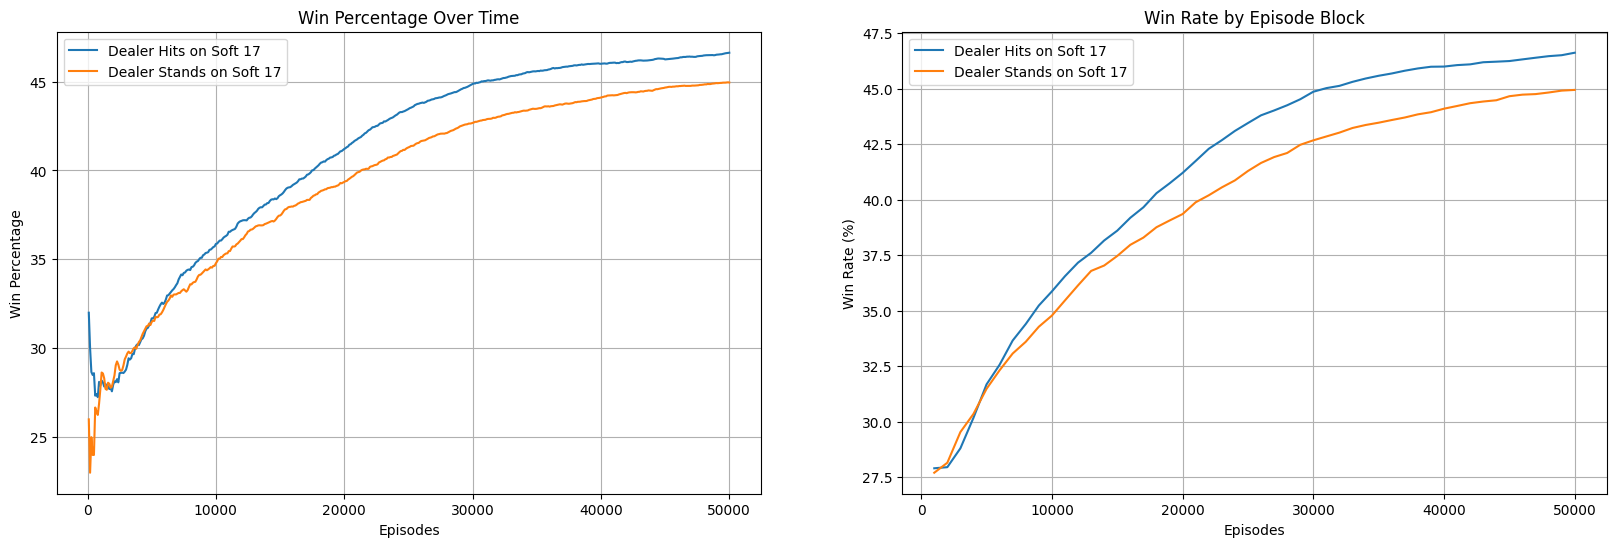

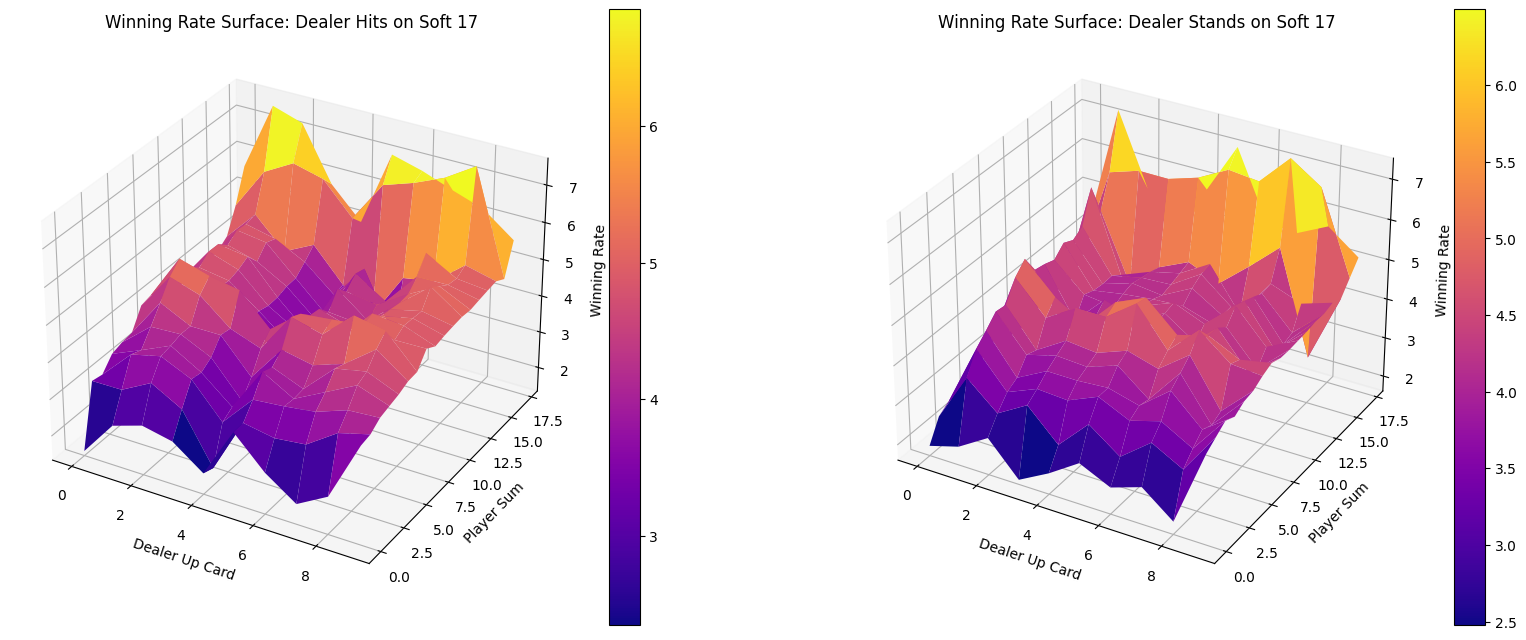

In [ ]:
# Main Execution
if __name__ == "__main__":
    num_episodes = 50000  # Increased number of episodes
    track_interval = 100
    state_space_size = (21 - 4 + 1) * 10  # Player sum (4-21) * Dealer up card (1-10)
    action_space_size = 4  # Hit, Stand, Double Down, Split
    block_size = 1000

    # States to track (example: (player_sum, dealer_up_card))
    track_states = [(12, 1), (18, 6), (20, 10)]

    # Rule Variation 1: Dealer Hits on Soft 17
    print("Rule Variation 1: Dealer Hits on Soft 17")
    agent = QLearningAgent(state_space_size, action_space_size)
    win_percentages_1, episode_blocks_1, overall_win_percentage_1, avg_reward_1, avg_win_rate_1, q_table_1 = evaluate_q_learning_agent(agent, num_episodes, track_states, track_interval, dealer_hits_on_soft_17=True)
    print(f"Winning Rate: {overall_win_percentage_1:.2f}%")
    print(f"Average Reward: {avg_reward_1:.4f}")
    print(f"Average Win Rate: {avg_win_rate_1:.4f}")
    print("")

    # Rule Variation 2: Dealer Stands on Soft 17
    print("Rule Variation 2: Dealer Stands on Soft 17")
    agent = QLearningAgent(state_space_size, action_space_size)
    win_percentages_2, episode_blocks_2, overall_win_percentage_2, avg_reward_2, avg_win_rate_2, q_table_2 = evaluate_q_learning_agent(agent, num_episodes, track_states, track_interval, dealer_hits_on_soft_17=False)
    print(f"Winning Rate: {overall_win_percentage_2:.2f}%")
    print(f"Average Reward: {avg_reward_2:.4f}")
    print(f"Average Win Rate: {avg_win_rate_2:.4f}")
    print("")

    # Plot the results adjacently
    plot_win_percentage_over_time_and_win_rate_by_episode_block(win_percentages_1, win_percentages_2, episode_blocks_1, episode_blocks_2, track_interval, block_size)

    # Calculate winning rates for the surface plot
    winning_rate_1 = (q_table_1.max(axis=1).reshape(18, 10) + 1) / 2  # Normalizing to [0, 1]
    winning_rate_2 = (q_table_2.max(axis=1).reshape(18, 10) + 1) / 2  # Normalizing to [0, 1]
    plot_3d_winning_rate_surfaces(winning_rate_1, winning_rate_2, 'Winning Rate Surface: Dealer Hits on Soft 17', 'Winning Rate Surface: Dealer Stands on Soft 17')


# **Complete Point-Count System with Rule Variations**

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define card values and other helper functions
def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def sum_hand(hand):
    total = sum(hand)
    num_aces = hand.count(1)

    while total + 10 <= 21 and num_aces > 0:
        total += 10
        num_aces -= 1

    return total

def is_bust(hand):
    return sum_hand(hand) > 21

def is_blackjack(hand):
    return sum_hand(hand) == 21 and len(hand) == 2

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)


In [ ]:
class Shoe:
    def __init__(self, num_decks=8, penetration=0.75):
        self.num_decks = num_decks
        self.penetration = penetration
        self.shoe = self.create_shoe()
        self.shuffle()

    def create_shoe(self):
        """Create a shoe with the given number of decks."""
        shoe = [card for card in range(1, 14) for _ in range(4)] * self.num_decks
        return shoe

    def shuffle(self):
        """Shuffle the shoe."""
        random.shuffle(self.shoe)

    def draw_card(self):
        """Draw a card from the shoe, reshuffle if the penetration point is reached."""
        if len(self.shoe) < (1 - self.penetration) * self.num_decks * 52:
            self.shoe = self.create_shoe()
            self.shuffle()
        return self.shoe.pop()


In [ ]:
class CompleteCountBlackjack:
    def __init__(self, dealer_stands_on_soft_17=False, early_surrender=False, num_decks=8, penetration=0.75):
        self.dealer_stands_on_soft_17 = dealer_stands_on_soft_17
        self.early_surrender = early_surrender
        self.shoe = Shoe(num_decks, penetration)
        self.reset_game()

    def reset_game(self):
        self.player_hand = [self.shoe.draw_card(), self.shoe.draw_card()]
        self.dealer_hand = [self.shoe.draw_card(), self.shoe.draw_card()]
        self.split_hand = None
        self.double_down = False
        self.point_count = 0
        self.unseen_cards = len(self.shoe.shoe)
        self.bet = 1
        self.update_count(self.player_hand + self.dealer_hand)

    def reset(self):
        self.reset_game()
        return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration())

    def step(self, action):
        if action == 1:  # Hit
            card = self.shoe.draw_card()
            self.player_hand.append(card)
            self.update_count([card])
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), -self.bet, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), 0, False
        elif action == 2:  # Double Down
            self.double_down = True
            self.bet *= 2
            card = self.shoe.draw_card()
            self.player_hand.append(card)
            self.update_count([card])
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), -self.bet, True
            else:
                return self.resolve_game()
        elif action == 3:  # Split
            self.split_hand = [self.player_hand.pop()]
            card1 = self.shoe.draw_card()
            card2 = self.shoe.draw_card()
            self.player_hand.append(card1)
            self.split_hand.append(card2)
            self.update_count([card1, card2])
            return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), 0, False
        elif action == 4 and self.early_surrender:  # Early Surrender
            if self.can_surrender_early(self.player_hand, self.dealer_hand[0]):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), -self.bet / 2, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), -self.bet, True  # Penalty for inappropriate early surrender
        else:  # Stand
            return self.resolve_game()

    def resolve_game(self):
        while sum_hand(self.dealer_hand) < 17 or (sum_hand(self.dealer_hand) == 17 and 1 in self.dealer_hand and not self.dealer_stands_on_soft_17):
            card = self.shoe.draw_card()
            self.dealer_hand.append(card)
            self.update_count([card])
        player_score = score(self.player_hand)
        dealer_score = score(self.dealer_hand)
        if self.split_hand:
            split_score = score(self.split_hand)
        else:
            split_score = None
        if is_blackjack(self.player_hand):
            reward = 1.5 * self.bet  # Higher reward for natural blackjack
        elif is_bust(self.dealer_hand) or player_score > dealer_score:
            reward = self.bet if not self.double_down else 2 * self.bet
        elif player_score == dealer_score:
            reward = 0
        else:
            reward = -self.bet if not self.double_down else -2 * self.bet
        return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_high_low_index(), self.get_deck_penetration()), reward, True

    def update_count(self, cards):
        for card in cards:
            if card in [2, 3, 4, 5, 6]:
                self.point_count += 1
            elif card in [10, 11, 12, 13]:
                self.point_count -= 1
        self.unseen_cards -= len(cards)

    def get_high_low_index(self):
        if self.unseen_cards == 0:
            return 0
        return self.point_count / (self.unseen_cards / 52)

    def get_deck_penetration(self):
        return 1 - (self.unseen_cards / self.shoe.num_decks / 52)

    def adjust_bet(self):
        high_low_index = self.get_high_low_index()
        if high_low_index <= 1:
            self.bet = 1
        elif high_low_index <= 2:
            self.bet = 2
        elif high_low_index <= 3:
            self.bet = 3
        elif high_low_index <= 4:
            self.bet = 4
        else:
            self.bet = 5

    def get_action(self, player_sum, dealer_up_card, high_low_index, deck_penetration, soft=False):
        # Adjust strategies based on deck penetration
        if deck_penetration > 0.75:
            # More aggressive strategy if deep into the deck
            if player_sum == 16 and dealer_up_card in [9, 10, 1] and high_low_index > 0:
                return 0  # Stand
            if player_sum == 15 and dealer_up_card in [10] and high_low_index > 4:
                return 0  # Stand
        # Detailed strategy for hitting and standing based on the High-Low Index
        if soft:
            if player_sum == 18:
                if dealer_up_card in [9, 10, 1]:
                    return 1 if high_low_index <= 2 else 0  # Hit if index is low, stand if high
                else:
                    return 0  # Stand
            elif player_sum == 19 and dealer_up_card == 6 and high_low_index > 1:
                return 1  # Hit
            else:
                return 0  # Stand
        else:
            if player_sum >= 17:
                return 0  # Stand
            elif player_sum <= 11:
                return 1  # Hit
            elif player_sum == 12:
                if dealer_up_card in [4, 5, 6] and high_low_index > 0:
                    return 0  # Stand
                else:
                    return 1  # Hit
            elif 13 <= player_sum <= 16:
                if dealer_up_card in [2, 3, 4, 5, 6]:
                    return 0  # Stand
                else:
                    return 1  # Hit
            return 1  # Default to Hit for other cases

    def should_double_down(self, player_sum, dealer_up_card, high_low_index, deck_penetration):
        # Adjust double down strategy based on deck penetration
        if deck_penetration > 0.75 and player_sum in [10, 11] and high_low_index > 1:
            return True
        # Detailed rules for doubling down based on the High-Low Index
        if player_sum == 9:
            if dealer_up_card in [3, 4, 5, 6] and high_low_index > 0:
                return True
        elif player_sum == 10:
            if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9] and high_low_index > -1:
                return True
        elif player_sum == 11:
            if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9, 10] and high_low_index > -2:
                return True
        return False

    def should_split(self, player_card, dealer_up_card, high_low_index, deck_penetration):
        # Adjust split strategy based on deck penetration
        if deck_penetration > 0.75 and player_card == 9 and dealer_up_card == 7 and high_low_index > 1:
            return True
        # Detailed rules for splitting based on the High-Low Index
        if player_card == 8:
            return True
        if player_card == 9:
            if dealer_up_card in [2, 3, 4, 5, 6, 8, 9] and high_low_index > 0:
                return True
        if player_card == 7:
            if dealer_up_card in [2, 3, 4, 5, 6, 7] and high_low_index > 1:
                return True
        if player_card == 6:
            if dealer_up_card in [2, 3, 4, 5, 6] and high_low_index > 2:
                return True
        if player_card == 2 or player_card == 3:
            if dealer_up_card in [2, 3, 4, 5, 6, 7] and high_low_index > 1:
                return True
        return False

    def should_take_insurance(self, high_low_index):
        # Take insurance if the High-Low Index is high enough
        return high_low_index > 3

    def can_surrender_early(self, player_hand, dealer_up_card):
        player_sum = sum_hand(player_hand)
        return (player_sum == 15 and dealer_up_card == 10) or \
               (player_sum == 16 and dealer_up_card in [9, 10, 1])


In [ ]:
class CompleteCountQLearningAgent:
    def __init__(self, state_space_size, action_space_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999):
        self.q_table = np.zeros((state_space_size, action_space_size))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 4)  # Explore (including early surrender action)
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] = self.q_table[state, action] + self.alpha * (target - predict)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


In [ ]:
# Mapping state to an index for Q-table
def state_to_index(player_sum, dealer_up_card, high_low_index, deck_penetration):
    if player_sum < 4:
        player_sum = 4
    elif player_sum > 21:
        player_sum = 21
    return (player_sum - 4) * 1000 + (dealer_up_card - 1) * 100 + int(high_low_index * 10 + 50) * 10 + int(deck_penetration * 10)  # Adjusting for high-low index and deck penetration

def evaluate_complete_count_agent(agent, num_episodes, track_states, track_interval=100, dealer_stands_on_soft_17=True, early_surrender=False):
    env = CompleteCountBlackjack(dealer_stands_on_soft_17, early_surrender)
    wins, draws, losses = 0, 0, 0
    total_reward = 0
    win_percentages = []
    cumulative_win_percentage = []
    q_value_progression = {state: {action: [] for action in range(5)} for state in track_states}  # Including early surrender action
    epsilon_values = []
    point_counts = []
    high_low_indices = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state_to_index(state[0], state[1], state[2], state[3])
        env.adjust_bet()  # Adjust the bet based on the High-Low Index
        done = False

        while not done:
            action = agent.choose_action(state_index)
            if action == 2 and not env.should_double_down(state[0], state[1], state[2], state[3]):
                action = agent.choose_action(state_index)  # Re-choose if double down is not appropriate
            if action == 3 and not env.should_split(state[0], state[1], state[2], state[3]):
                action = agent.choose_action(state_index)  # Re-choose if split is not appropriate
            next_state, reward, done = env.step(action)
            next_state_index = state_to_index(next_state[0], next_state[1], next_state[2], next_state[3])
            agent.learn(state_index, action, reward, next_state_index)
            state_index = next_state_index

        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

        epsilon_values.append(agent.epsilon)
        point_counts.append(env.point_count)
        high_low_indices.append(env.get_high_low_index())

        if (episode + 1) % track_interval == 0:
            win_percentage = wins / (episode + 1) * 100
            win_percentages.append(win_percentage)

        cumulative_win_percentage.append(wins / (episode + 1) * 100)

        if (episode + 1) % track_interval == 0:
            for (player_sum, dealer_up_card, high_low_index, deck_penetration) in track_states:
                state_index = state_to_index(player_sum, dealer_up_card, high_low_index, deck_penetration)
                for action in range(5):  # Including early surrender action
                    q_value_progression[(player_sum, dealer_up_card, high_low_index, deck_penetration)][action].append(agent.q_table[state_index, action])

        agent.decay_epsilon()

    avg_reward = total_reward / num_episodes
    avg_win_rate = wins / num_episodes
    overall_win_percentage = wins / num_episodes * 100

    return win_percentages, cumulative_win_percentage, q_value_progression, avg_reward, avg_win_rate, overall_win_percentage, epsilon_values, point_counts, high_low_indices


In [ ]:
def plot_win_percentages(win_percentages_s17, win_percentages_es, track_interval):
    fig, ax = plt.subplots(figsize=(10, 5))

    episodes = range(track_interval, len(win_percentages_s17) * track_interval + 1, track_interval)
    ax.plot(episodes, win_percentages_s17, label='Dealer Stands on Soft 17')
    ax.plot(episodes, win_percentages_es, label='Early Surrender', color='orange')

    ax.set_xlabel('Episodes')
    ax.set_ylabel('Win Percentage')
    ax.set_title('Win Percentage Over Time')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_epsilon_decay(epsilon_values_s17, epsilon_values_es):
    fig, ax = plt.subplots(figsize=(10, 5))

    episodes = range(len(epsilon_values_s17))
    ax.plot(episodes, epsilon_values_s17, label='Dealer Stands on Soft 17')
    ax.plot(episodes, epsilon_values_es, label='Early Surrender', color='orange')

    ax.set_xlabel('Episodes')
    ax.set_ylabel('Epsilon Value')
    ax.set_title('Epsilon Decay Over Episodes')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


## Win Percent Over Time and Epsilon Decay

Evaluating Rule Variation 1: Dealer Stands on Soft 17
Win Percentage: 41.54%
Avg Reward: -0.13105
Avg Win Rate: 0.4154

Evaluating Rule Variation 2: Early Surrender
Win Percentage: 39.98%
Avg Reward: -0.1808
Avg Win Rate: 0.3998


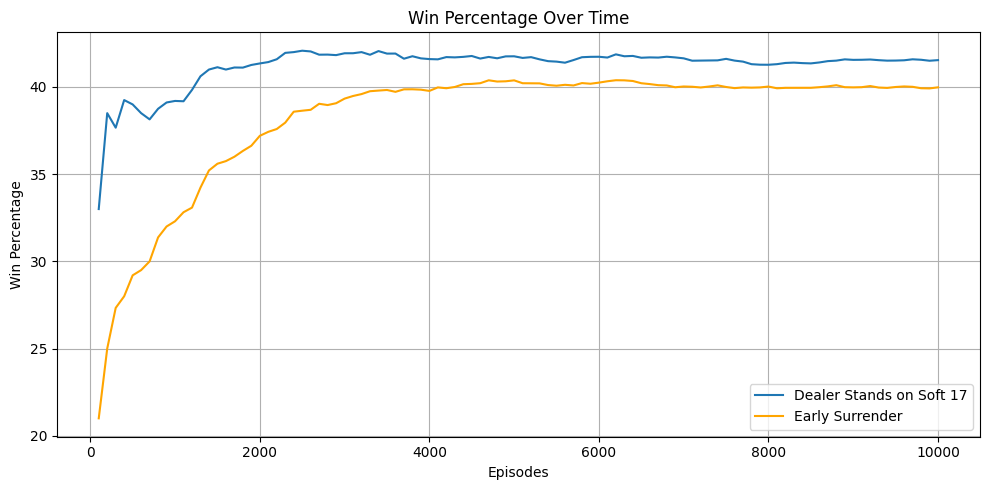

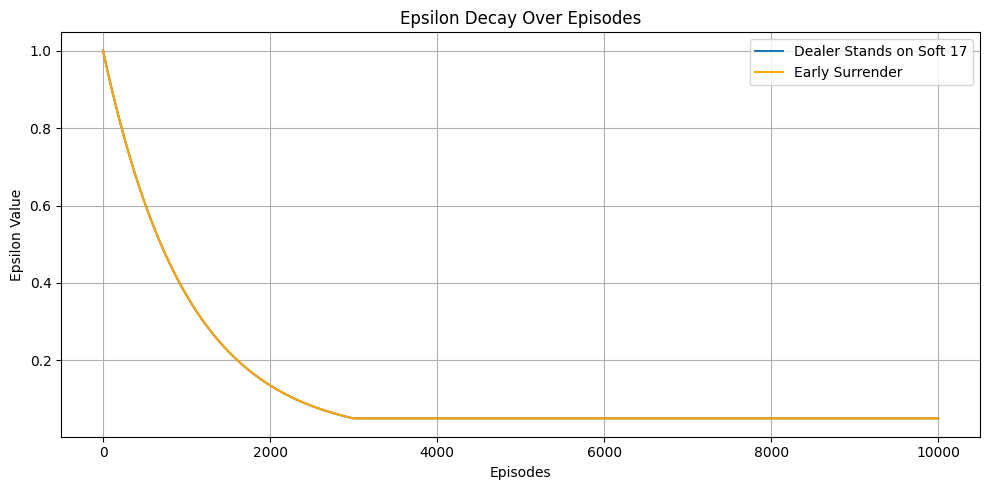

In [ ]:
# Example usage
num_episodes = 10000
track_interval = 100
state_space_size = (21 - 4 + 1) * 1000 * 10  # Player sum (4-21) * Dealer up card (1-10) * High-Low Index (-5 to +5) * Deck penetration (0-10)
action_space_size = 5  # Hit, Stand, Double Down, Split, Early Surrender

# States to track (example: (player_sum, dealer_up_card, high_low_index, deck_penetration))
track_states = [(12, 1, 0, 0.5), (18, 6, 0.5, 0.5), (20, 10, -0.5, 0.5)]

agent1 = CompleteCountQLearningAgent(state_space_size, action_space_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999)
agent2 = CompleteCountQLearningAgent(state_space_size, action_space_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999)

# Evaluate rule variation 1: Dealer stands on soft 17
print("Evaluating Rule Variation 1: Dealer Stands on Soft 17")
win_percentages_s17, cumulative_win_percentage_s17, q_value_progression_s17, avg_reward_s17, avg_win_rate_s17, overall_win_percentage_s17, epsilon_values_s17, point_counts_s17, high_low_indices_s17 = evaluate_complete_count_agent(agent1, num_episodes, track_states, track_interval, dealer_stands_on_soft_17=True, early_surrender=False)
print(f"Win Percentage: {overall_win_percentage_s17}%")
print(f"Avg Reward: {avg_reward_s17}")
print(f"Avg Win Rate: {avg_win_rate_s17}")

# Evaluate rule variation 2: Early Surrender
print("\nEvaluating Rule Variation 2: Early Surrender")
win_percentages_es, cumulative_win_percentage_es, q_value_progression_es, avg_reward_es, avg_win_rate_es, overall_win_percentage_es, epsilon_values_es, point_counts_es, high_low_indices_es = evaluate_complete_count_agent(agent2, num_episodes, track_states, track_interval, dealer_stands_on_soft_17=False, early_surrender=True)
print(f"Win Percentage: {overall_win_percentage_es}%")
print(f"Avg Reward: {avg_reward_es}")
print(f"Avg Win Rate: {avg_win_rate_es}")

# Plot Win Percentages of both variations
plot_win_percentages(win_percentages_s17, win_percentages_es, track_interval)

# Plot Epsilon Decay Over Episodes for both variations
plot_epsilon_decay(epsilon_values_s17, epsilon_values_es)


# **Enhanced Complete Point-Count System with Zen Count**

Evaluating Rule Variation 1: Dealer Stands on Soft 17
Win Percentage: 41.02%
Avg Reward: -0.1548
Avg Win Rate: 0.4102

Evaluating Rule Variation 2: Early Surrender
Win Percentage: 40.6%
Avg Reward: -0.17105
Avg Win Rate: 0.406


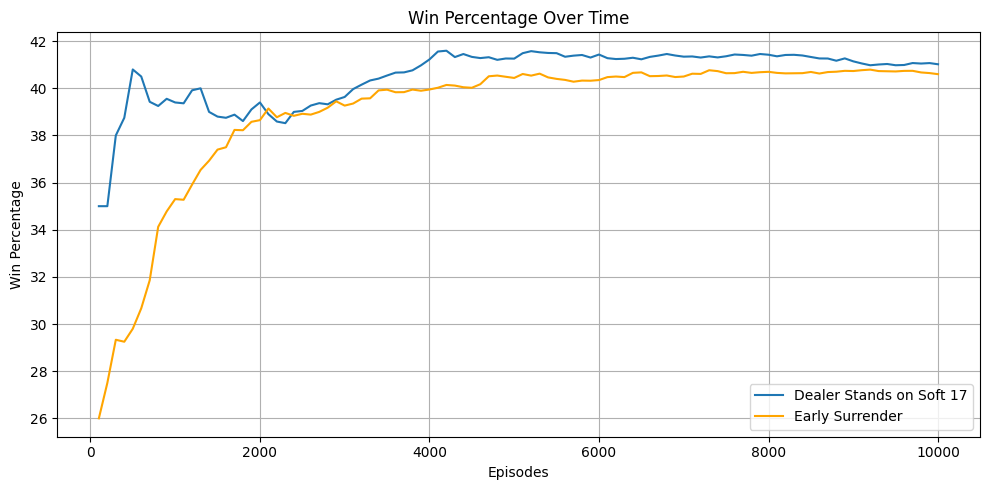

<ipython-input-7-a7defdc6bac6>:376: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


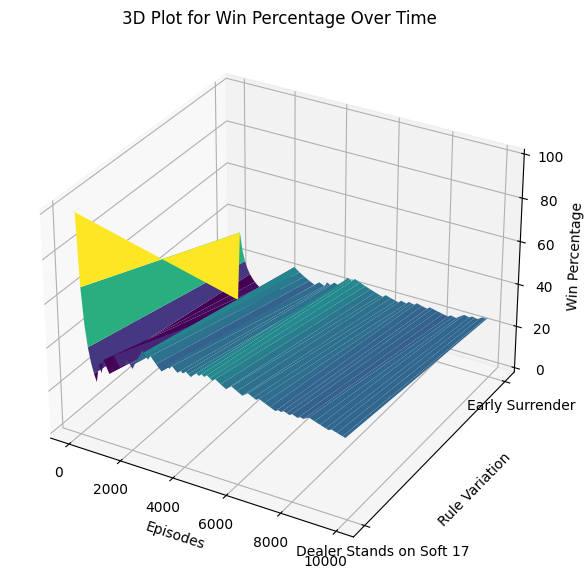

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define card values and other helper functions
def draw_card():
    return min(random.randint(1, 13), 10)

def draw_hand():
    return [draw_card(), draw_card()]

def sum_hand(hand):
    total = sum(hand)
    num_aces = hand.count(1)

    while total + 10 <= 21 and num_aces > 0:
        total += 10
        num_aces -= 1

    return total

def is_bust(hand):
    return sum_hand(hand) > 21

def is_blackjack(hand):
    return sum_hand(hand) == 21 and len(hand) == 2

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

# Shoe Class for Deck Management
class Shoe:
    def __init__(self, num_decks=8, penetration=0.75):
        self.num_decks = num_decks
        self.penetration = penetration
        self.shoe = self.create_shoe()
        self.shuffle()

    def create_shoe(self):
        """Create a shoe with the given number of decks."""
        shoe = [card for card in range(1, 14) for _ in range(4)] * self.num_decks
        return shoe

    def shuffle(self):
        """Shuffle the shoe."""
        random.shuffle(self.shoe)

    def draw_card(self):
        """Draw a card from the shoe, reshuffle if the penetration point is reached."""
        if len(self.shoe) < (1 - self.penetration) * self.num_decks * 52:
            self.shoe = self.create_shoe()
            self.shuffle()
        return self.shoe.pop()

# Blackjack Environment Class
class CompleteCountBlackjack:
    def __init__(self, dealer_stands_on_soft_17=False, early_surrender=False, num_decks=8, penetration=0.75):
        self.dealer_stands_on_soft_17 = dealer_stands_on_soft_17
        self.early_surrender = early_surrender
        self.shoe = Shoe(num_decks, penetration)
        self.reset_game()

    def reset_game(self):
        self.player_hand = [self.shoe.draw_card(), self.shoe.draw_card()]
        self.dealer_hand = [self.shoe.draw_card(), self.shoe.draw_card()]
        self.split_hand = None
        self.double_down = False
        self.point_count = 0
        self.unseen_cards = len(self.shoe.shoe)
        self.bet = 1
        self.update_count(self.player_hand + self.dealer_hand)

    def reset(self):
        self.reset_game()
        return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration())

    def step(self, action):
        if action == 1:  # Hit
            card = self.shoe.draw_card()
            self.player_hand.append(card)
            self.update_count([card])
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration()), -self.bet, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration()), 0, False
        elif action == 2:  # Double Down
            self.double_down = True
            self.bet *= 2
            card = self.shoe.draw_card()
            self.player_hand.append(card)
            self.update_count([card])
            if is_bust(self.player_hand):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration()), -self.bet, True
            else:
                return self.resolve_game()
        elif action == 3:  # Split
            self.split_hand = [self.player_hand.pop()]
            card1 = self.shoe.draw_card()
            card2 = self.shoe.draw_card()
            self.player_hand.append(card1)
            self.split_hand.append(card2)
            self.update_count([card1, card2])
            return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration()), 0, False
        elif action == 4 and self.early_surrender:  # Early Surrender
            if self.can_surrender_early(self.player_hand, self.dealer_hand[0]):
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration()), -self.bet / 2, True
            else:
                return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration()), -self.bet, True  # Penalty for inappropriate early surrender
        else:  # Stand
            return self.resolve_game()

    def resolve_game(self):
        while sum_hand(self.dealer_hand) < 17 or (sum_hand(self.dealer_hand) == 17 and 1 in self.dealer_hand and not self.dealer_stands_on_soft_17):
            card = self.shoe.draw_card()
            self.dealer_hand.append(card)
            self.update_count([card])
        player_score = score(self.player_hand)
        dealer_score = score(self.dealer_hand)
        if self.split_hand:
            split_score = score(self.split_hand)
        else:
            split_score = None
        if is_blackjack(self.player_hand):
            reward = 1.5 * self.bet  # Higher reward for natural blackjack
        elif is_bust(self.dealer_hand) or player_score > dealer_score:
            reward = self.bet if not self.double_down else 2 * self.bet
        elif player_score == dealer_score:
            reward = 0
        else:
            reward = -self.bet if not self.double_down else -2 * self.bet
        return (sum_hand(self.player_hand), self.dealer_hand[0], self.get_zen_index(), self.get_deck_penetration()), reward, True

    def update_count(self, cards):
        for card in cards:
            if card in [2, 3, 7]:
                self.point_count += 1
            elif card in [4, 5, 6]:
                self.point_count += 2
            elif card == 9:
                self.point_count -= 1
            elif card in [10, 11, 12, 13, 1]:
                self.point_count -= 2
        self.unseen_cards -= len(cards)

    def get_zen_index(self):
        if self.unseen_cards == 0:
            return 0
        return self.point_count / (self.unseen_cards / 52)

    def get_deck_penetration(self):
        return 1 - (self.unseen_cards / self.shoe.num_decks / 52)

    def adjust_bet(self):
        zen_index = self.get_zen_index()
        if zen_index <= 1:
            self.bet = 1
        elif zen_index <= 2:
            self.bet = 2
        elif zen_index <= 3:
            self.bet = 3
        elif zen_index <= 4:
            self.bet = 4
        else:
            self.bet = 5

    def get_action(self, player_sum, dealer_up_card, zen_index, deck_penetration, soft=False):
        # Adjust strategies based on deck penetration
        if deck_penetration > 0.75:
            # More aggressive strategy if deep into the deck
            if player_sum == 16 and dealer_up_card in [9, 10, 1] and zen_index > 0:
                return 0  # Stand
            if player_sum == 15 and dealer_up_card in [10] and zen_index > 4:
                return 0  # Stand
        # Detailed strategy for hitting and standing based on the Zen Count Index
        if soft:
            if player_sum == 18:
                if dealer_up_card in [9, 10, 1]:
                    return 1 if zen_index <= 2 else 0  # Hit if index is low, stand if high
                else:
                    return 0  # Stand
            elif player_sum == 19 and dealer_up_card == 6 and zen_index > 1:
                return 1  # Hit
            else:
                return 0  # Stand
        else:
            if player_sum >= 17:
                return 0  # Stand
            elif player_sum <= 11:
                return 1  # Hit
            elif player_sum == 12:
                if dealer_up_card in [4, 5, 6] and zen_index > 0:
                    return 0  # Stand
                else:
                    return 1  # Hit
            elif 13 <= player_sum <= 16:
                if dealer_up_card in [2, 3, 4, 5, 6]:
                    return 0  # Stand
                else:
                    return 1  # Hit
            return 1  # Default to Hit for other cases

    def should_double_down(self, player_sum, dealer_up_card, zen_index, deck_penetration):
        # Adjust double down strategy based on deck penetration
        if deck_penetration > 0.75 and player_sum in [10, 11] and zen_index > 1:
            return True
        # Detailed rules for doubling down based on the Zen Count Index
        if player_sum == 9:
            if dealer_up_card in [3, 4, 5, 6] and zen_index > 0:
                return True
        elif player_sum == 10:
            if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9] and zen_index > -1:
                return True
        elif player_sum == 11:
            if dealer_up_card in [2, 3, 4, 5, 6, 7, 8, 9, 10] and zen_index > -2:
                return True
        return False

    def should_split(self, player_card, dealer_up_card, zen_index, deck_penetration):
        # Adjust split strategy based on deck penetration
        if deck_penetration > 0.75 and player_card == 9 and dealer_up_card == 7 and zen_index > 1:
            return True
        # Detailed rules for splitting based on the Zen Count Index
        if player_card == 8:
            return True
        if player_card == 9:
            if dealer_up_card in [2, 3, 4, 5, 6, 8, 9] and zen_index > 0:
                return True
        if player_card == 7:
            if dealer_up_card in [2, 3, 4, 5, 6, 7] and zen_index > 1:
                return True
        if player_card == 6:
            if dealer_up_card in [2, 3, 4, 5, 6] and zen_index > 2:
                return True
        if player_card == 2 or player_card == 3:
            if dealer_up_card in [2, 3, 4, 5, 6, 7] and zen_index > 1:
                return True
        return False

    def should_take_insurance(self, zen_index):
        # Take insurance if the Zen Count Index is high enough
        return zen_index > 3

    def can_surrender_early(self, player_hand, dealer_up_card):
        player_sum = sum_hand(player_hand)
        return (player_sum == 15 and dealer_up_card == 10) or \
               (player_sum == 16 and dealer_up_card in [9, 10, 1])

# Q-Learning Agent Class
class CompleteCountQLearningAgent:
    def __init__(self, state_space_size, action_space_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999):
        self.q_table = np.zeros((state_space_size, action_space_size))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 4)  # Explore (including early surrender action)
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] = self.q_table[state, action] + self.alpha * (target - predict)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

# Mapping state to an index for Q-table
def state_to_index(player_sum, dealer_up_card, zen_index, deck_penetration):
    if player_sum < 4:
        player_sum = 4
    elif player_sum > 21:
        player_sum = 21
    return (player_sum - 4) * 1000 + (dealer_up_card - 1) * 100 + int(zen_index * 10 + 50) * 10 + int(deck_penetration * 10)  # Adjusting for zen index and deck penetration

# Evaluation Function
def evaluate_complete_count_agent(agent, num_episodes, track_states, track_interval=100, dealer_stands_on_soft_17=True, early_surrender=False):
    env = CompleteCountBlackjack(dealer_stands_on_soft_17, early_surrender)
    wins, draws, losses = 0, 0, 0
    total_reward = 0
    win_percentages = []
    cumulative_win_percentage = []
    q_value_progression = {state: {action: [] for action in range(5)} for state in track_states}  # Including early surrender action
    epsilon_values = []
    point_counts = []
    zen_indices = []

    for episode in range(num_episodes):
        state = env.reset()
        state_index = state_to_index(state[0], state[1], state[2], state[3])
        env.adjust_bet()  # Adjust the bet based on the Zen Count Index
        done = False

        while not done:
            action = agent.choose_action(state_index)
            if action == 2 and not env.should_double_down(state[0], state[1], state[2], state[3]):
                action = agent.choose_action(state_index)  # Re-choose if double down is not appropriate
            if action == 3 and not env.should_split(state[0], state[1], state[2], state[3]):
                action = agent.choose_action(state_index)  # Re-choose if split is not appropriate
            next_state, reward, done = env.step(action)
            next_state_index = state_to_index(next_state[0], next_state[1], next_state[2], next_state[3])
            agent.learn(state_index, action, reward, next_state_index)
            state_index = next_state_index

        total_reward += reward
        if reward > 0:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

        epsilon_values.append(agent.epsilon)
        point_counts.append(env.point_count)
        zen_indices.append(env.get_zen_index())

        if (episode + 1) % track_interval == 0:
            win_percentage = wins / (episode + 1) * 100
            win_percentages.append(win_percentage)

        cumulative_win_percentage.append(wins / (episode + 1) * 100)

        if (episode + 1) % track_interval == 0:
            for (player_sum, dealer_up_card, zen_index, deck_penetration) in track_states:
                state_index = state_to_index(player_sum, dealer_up_card, zen_index, deck_penetration)
                for action in range(5):  # Including early surrender action
                    q_value_progression[(player_sum, dealer_up_card, zen_index, deck_penetration)][action].append(agent.q_table[state_index, action])

        agent.decay_epsilon()

    avg_reward = total_reward / num_episodes
    avg_win_rate = wins / num_episodes
    overall_win_percentage = wins / num_episodes * 100

    return win_percentages, cumulative_win_percentage, q_value_progression, avg_reward, avg_win_rate, overall_win_percentage, epsilon_values, point_counts, zen_indices

# Plotting Functions
def plot_win_percentages(win_percentages_s17, win_percentages_es, track_interval):
    fig, ax = plt.subplots(figsize=(10, 5))

    episodes = range(track_interval, len(win_percentages_s17) * track_interval + 1, track_interval)
    ax.plot(episodes, win_percentages_s17, label='Dealer Stands on Soft 17')
    ax.plot(episodes, win_percentages_es, label='Early Surrender', color='orange')

    ax.set_xlabel('Episodes')
    ax.set_ylabel('Win Percentage')
    ax.set_title('Win Percentage Over Time')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_3d_win_percentage(cumulative_win_percentage_s17, cumulative_win_percentage_es, num_episodes, track_interval):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    episodes = np.arange(0, num_episodes, track_interval)
    X, Y = np.meshgrid(episodes, [1, 2])
    Z = np.array([cumulative_win_percentage_s17[:len(episodes)], cumulative_win_percentage_es[:len(episodes)]])

    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel('Episodes')
    ax.set_ylabel('Rule Variation')
    ax.set_zlabel('Win Percentage')
    ax.set_title('3D Plot for Win Percentage Over Time')
    ax.set_yticks([1, 2])
    ax.set_yticklabels(['Dealer Stands on Soft 17', 'Early Surrender'])

    plt.tight_layout()
    plt.show()

# Main Execution
num_episodes = 10000
track_interval = 100
state_space_size = (21 - 4 + 1) * 1000 * 10  # Player sum (4-21) * Dealer up card (1-10) * Zen Index (-5 to +5) * Deck penetration (0-10)
action_space_size = 5  # Hit, Stand, Double Down, Split, Early Surrender

# States to track (example: (player_sum, dealer_up_card, zen_index, deck_penetration))
track_states = [(12, 1, 0, 0.5), (18, 6, 0.5, 0.5), (20, 10, -0.5, 0.5)]

agent1 = CompleteCountQLearningAgent(state_space_size, action_space_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999)
agent2 = CompleteCountQLearningAgent(state_space_size, action_space_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999)

# Evaluate rule variation 1: Dealer stands on soft 17
print("Evaluating Rule Variation 1: Dealer Stands on Soft 17")
win_percentages_s17, cumulative_win_percentage_s17, q_value_progression_s17, avg_reward_s17, avg_win_rate_s17, overall_win_percentage_s17, epsilon_values_s17, point_counts_s17, zen_indices_s17 = evaluate_complete_count_agent(agent1, num_episodes, track_states, track_interval, dealer_stands_on_soft_17=True, early_surrender=False)
print(f"Win Percentage: {overall_win_percentage_s17}%")
print(f"Avg Reward: {avg_reward_s17}")
print(f"Avg Win Rate: {avg_win_rate_s17}")

# Evaluate rule variation 2: Early Surrender
print("\nEvaluating Rule Variation 2: Early Surrender")
win_percentages_es, cumulative_win_percentage_es, q_value_progression_es, avg_reward_es, avg_win_rate_es, overall_win_percentage_es, epsilon_values_es, point_counts_es, zen_indices_es = evaluate_complete_count_agent(agent2, num_episodes, track_states, track_interval, dealer_stands_on_soft_17=False, early_surrender=True)
print(f"Win Percentage: {overall_win_percentage_es}%")
print(f"Avg Reward: {avg_reward_es}")
print(f"Avg Win Rate: {avg_win_rate_es}")

# Plot Win Percentages of both variations
plot_win_percentages(win_percentages_s17, win_percentages_es, track_interval)

# Plot 3D Win Percentage Over Episodes for both variations
plot_3d_win_percentage(cumulative_win_percentage_s17, cumulative_win_percentage_es, num_episodes, track_interval)
